In [1]:
import numpy as np
import ipdb
import pandas as pd
from copy import deepcopy
import pickle
import matplotlib.pyplot as plt

## Load data

In [2]:
#reload object from file


file2 = open(r'/home/ahaimovici/Documents/Teaching/Rectangle_Game/C3/Data/Individual/Teachers.pkl', 'rb')
Teachers = pickle.load(file2)
file2.close()

file2 = open(r'/home/ahaimovici/Documents/Teaching/Rectangle_Game/C3/Data/Individual/Learners.pkl', 'rb')
Learners = pickle.load(file2)
file2.close()


## Check consistency in learners and remove bad trials and bad learners

In [3]:
Errors=[]; # trials labeled as inconsistent which are consistent and viceversa. This is happened in a few trials where subjects clicked outside or in the border of the canvas

New_Learners=[];

for subject in Learners:
    n_trial=-1;
    s1=deepcopy(subject);
    New_Learners.append(s1);
    New_Learners[len(New_Learners)-1]['trials']=[];
    for trial in subject['trials']:        
        n_trial=n_trial+1;
        box=trial['Box'];
        consistent=True;
        for circle in trial['Circles']:
            if not(circle[0]>=box[0] and circle[0]<=box[1] and circle[1]>=box[2] and circle[1]<=box[3]):
                consistent=False;
        for cross in trial['Crosses']:
            if cross[0]>=box[0] and cross[0]<=box[1] and cross[1]>=box[2] and cross[1]<=box[3]:
                consistent=False;
        if consistent and trial['Consistent']:
            New_Learners[len(New_Learners)-1]['trials'].append(trial);
                
Learners=New_Learners;

New_Learners=[];
for s in Learners:
    if s['inconsistent_trials']<0.1:
        New_Learners.append(s)        
Learners=New_Learners;     
            
            

In [4]:


def individual_histogram(subject): # as in the paper
    n_bins=3;
    canvas_size=974;
    inner_bins=np.zeros([n_bins,n_bins]); 
    outer_bins=np.zeros([n_bins+1,n_bins+1]);             
    n_trial=-1;
    for trial in subject['trials']:
            n_trial=n_trial+1;
            box=trial['Box'];
            width=box[1]-box[0];
            height=box[3]-box[2];                
            for circle in trial['Circles']:
                x=circle[0]-box[0];
                y=circle[1]-box[2];
                x_bin=np.int(np.floor(x/(width/n_bins)));
                y_bin=np.int(np.floor(y/(height/n_bins)));
                if(x_bin==3):
                    x_bin=2;
                if(y_bin==3):
                    y_bin=2;                
                inner_bins[x_bin,y_bin ]=inner_bins[x_bin,y_bin]+1;                
            for cross in trial['Crosses']:
                if (cross[0]-box[0])<0: #left side
                    x=box[0]-cross[0];
                    x_bin=np.int(np.floor(x/(box[0]/n_bins)))+1; # bins 1,2 or 3
                elif cross[0]>box[1]: #right side
                    x=cross[0]-box[1];
                    x_bin=np.int(np.floor(x/((canvas_size-box[1])/n_bins)))+1;
                else: # above or below the box
                    x_bin=0;                
                if (cross[1]-box[2])<0: # above
                    y=box[2]-cross[1];
                    y_bin=np.int(np.floor(y/(box[2]/n_bins)))+1;
                elif cross[1]>box[3]:
                    y=cross[1]-box[3];
                    y_bin=np.int(np.floor(y/((canvas_size-box[3])/n_bins)))+1;
                else:
                    y_bin=0;
                if x_bin>3 or y_bin>3:
                    ipdb.set_trace()
                outer_bins[x_bin,y_bin]=outer_bins[x_bin,y_bin]+1;            
    return inner_bins, outer_bins;


def distance_to_box(subject):
    # returns a list with the distance to the nearest side of the box
    sample_dist=[];
    for trial in subject['trials']:    
        box=trial['Box'];
        corner_1=[box[0],box[2]];
        corner_2=[box[0],box[3]];
        corner_3=[box[1],box[2]];
        corner_4=[box[1],box[3]];    
        for sample in trial['Circles']:                       
            dist=min(sample[0]-box[0],box[1]-sample[0],sample[1]-box[2],box[3]-sample[1]);                        
            sample_dist.append(dist);
        for sample in trial['Crosses']:
            if (sample[0]>=box[0])and(sample[0]<=box[1]): # top or bottom
                dist=min(abs(sample[1]-box[2]),abs(sample[1]-box[3]));
            elif(sample[1]>=box[2])and(sample[1]<=box[3]): # right or left
                dist=min(abs(sample[0]-box[0]),abs(sample[0]-box[1]));
            else:                    
                dist=min(euclidean_dist(sample,corner_1),euclidean_dist(sample,corner_2),euclidean_dist(sample,corner_3),euclidean_dist(sample,corner_4));                
            sample_dist.append(dist);             
    return sample_dist;
    




def distance_to_corner(subject):
    # returns a list with the distance to the nearest corner of every sample
    sample_dist=[];
    for trial in subject['trials']:    
        box=trial['Box'];
        corner_1=[box[0],box[2]];
        corner_2=[box[0],box[3]];
        corner_3=[box[1],box[2]];
        corner_4=[box[1],box[3]];    
        for sample in trial['Circles']:
            dist=np.inf;        
            dist=min(dist,euclidean_dist(sample,corner_1));
            dist=min(dist,euclidean_dist(sample,corner_2));
            dist=min(dist,euclidean_dist(sample,corner_3));
            dist=min(dist,euclidean_dist(sample,corner_4));
            sample_dist.append(dist);
        for sample in trial['Crosses']:
            dist=np.inf;        
            dist=min(dist,euclidean_dist(sample,corner_1));
            dist=min(dist,euclidean_dist(sample,corner_2));
            dist=min(dist,euclidean_dist(sample,corner_3));
            dist=min(dist,euclidean_dist(sample,corner_4));
            sample_dist.append(dist);                
    return sample_dist;
        
def euclidean_dist(X,Y):
    return np.sqrt((X[0]-Y[0])**2+(X[1]-Y[1])**2);
       
        
def flat_list(some_list):
    # turns a list of lists into a single flat list
    elements=[]
    for item in some_list:
        if type(item) == type([]):
            elements += flat_list(item)
        else:
            elements.append(item)
    return elements
        
def draw_trial(trial):
    box=trial['Box'];
    fig=plt.figure;
    plt.plot([box[0],box[0],box[1],box[1],box[0]],[box[3],box[2],box[2],box[3],box[3]],'b')
    for circle in trial['Circles']:
        plt.plot(circle[0],circle[1],'og')    
    for cross in trial['Crosses']:
        plt.plot(cross[0],cross[1],'xk')                
    plt.show()
    plt.ylim([0,972]);
    plt.xlim([0,972]);
    
def plot_inner_histo(histo_inside):
    fig=plt.figure();      
    plt.pcolor(histo_inside,cmap='Greys')     
    plt.colorbar();    
    plt.plot([0,3,3,0,0],[0,0,3,3,0],'b')
    plt.xlim([-0.5,3.5])
    plt.ylim([-0.5,3.5])
    plt.tick_params(bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)    
    plt.show()
    
    
    
def plot_outer_histo(histo_outside):
    fig=plt.figure();
    plt.title('')
    plt.pcolor(histo_outside,cmap='Greys')
    plt.colorbar();
    plt.plot([0,1,1,0,0],[0,0,1,1,0],'b')
    plt.xlim([-0.03,4])
    plt.ylim([-0.01,4])    
    plt.tick_params(bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)
    plt.show()
    

## DISTANCIAS A LAS ESQUINAS

Rol=Learners;

Edades=[];
for subject in Rol:
    Edades.append(subject['age']);
Edades=np.sort(Edades);

mx=0;
i=0;
n_trials=[];
fig=plt.figure();
Edades=12;
for e in np.unique(Edades):
    D=[];
    N=0;
    for subject in Rol:     
        if (subject['understood'] and subject['age']==e and len(subject['trials'])>2):
            n_trials.append(len(subject['trials']));
            N=N+1;
            #dists=distance_to_corner(subject);
            dists=distance_to_box(subject);
            #ind_hist=plt.hist(dists);
            #norm_hist = [n/sum(ind_hist[0]) for n in ind_hist[0]];            
            
            dists[:] = [x / 972 for x in dists];
            D.append(dists);            
            print(subject['Id'])
            [inner,outer]=individual_histogram(subject);               
            plot_inner_histo(inner);
            plot_outer_histo(outer);  
            fig=plt.figure();  
            print("distance to box")
            plt.hist(dists);
            plt.show();
            
                                    
    '''
    D=flat_list(D);
    mx=max(mx,max(D));            
    i=i+1;    
    plt.figure;
    plt.hist(D)    ;
    plt.title('Edad='+str(e)+' N='+str(N));    
    plt.xlabel('Distance to corner')
    plt.ylabel('Number of examples')    
    plt.xlim([0,1000])         
    #fig.savefig('Distance_to_corner_Edad_'+str(e)+'_teachers', bbox_inches='tight')
    plt.show();
    '''
            

In [5]:

Edades=[];
G=[];
Rol=Teachers;
for subject in Rol:
    Edades.append(subject['age']);    
    
Edades=np.sort(Edades);
unique_elements, counts_elements = np.unique(Edades, return_counts=True)

n_F=[];
for e in unique_elements:
    n=0;
    for subject in Rol:        
        if subject['age']==e and subject['gender']=='F':
            n+=1;
    n_F.append(n);

print(len(Rol))

for i in range(0,len(unique_elements)):
    print(unique_elements[i],counts_elements[i],n_F[i])




53
5 5 2
6 6 4
7 7 3
8 3 1
9 6 3
10 6 2
11 4 1
12 2 1
13 1 1
14 1 1
16 1 1
18 2 2
20 1 0
32 1 1
40 2 1
41 1 0
42 1 0
44 1 1
49 1 0
57 1 1


In [9]:
for t in Teachers:
    print(t['Id'])

4
41
85
26
96
76
91
31
107
20
25
99
70
89
84
80
34
51
1
46
110
65
64
66
75
55
39
104
82
3
11
303
249
48
43
275
212
251
291
301
33
247
201
278
44
304
279
220
236
286
239
285
259


##  HISTOGRAMAS COMO EN EL PAPER

5
[241]
Edades: 5 N: 1


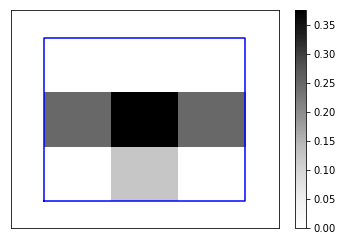

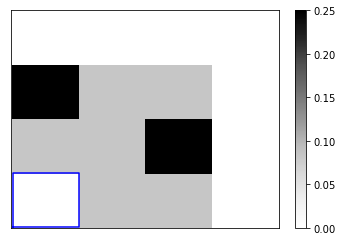

6
[48, 90, 294]
Edades: 6 N: 3


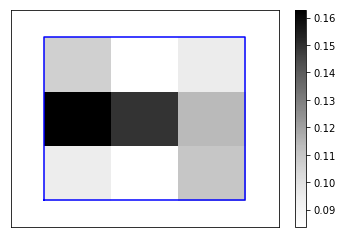

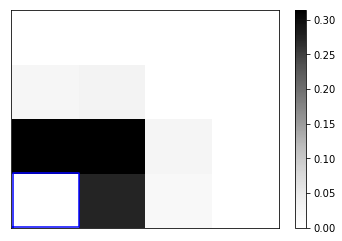

7
[283, 296]
Edades: 7 N: 2


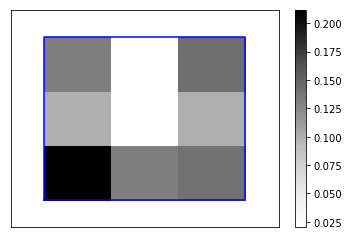

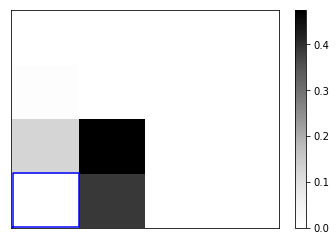

8
[67, 86, 254, 272, 282, 302]
Edades: 8 N: 6


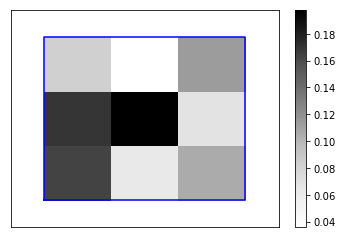

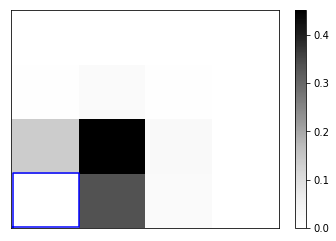

9
[49, 246, 268, 270, 276, 281]
Edades: 9 N: 6


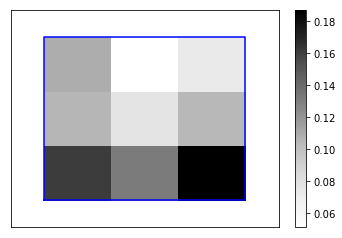

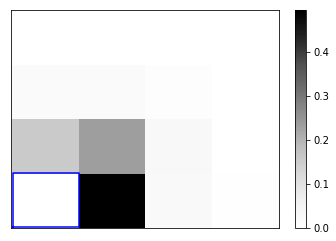

10
[17, 36, 56, 83, 263, 300]
Edades: 10 N: 6


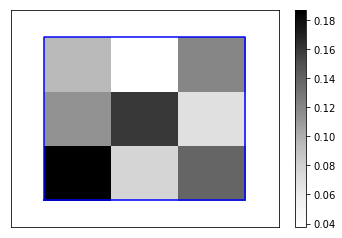

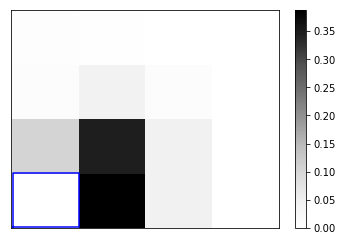

11
[14, 58, 84, 271]
Edades: 11 N: 4


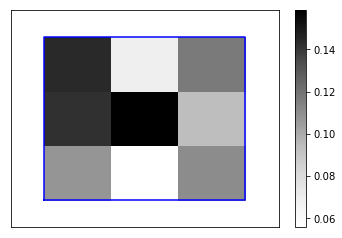

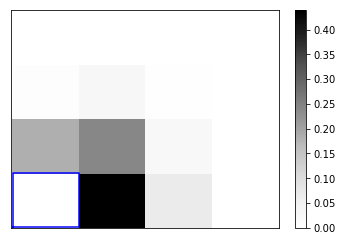

12
[9, 38, 88, 92]
Edades: 12 N: 4


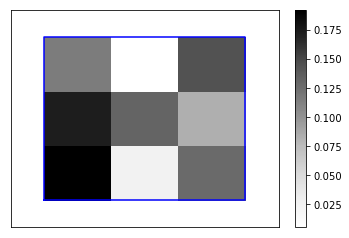

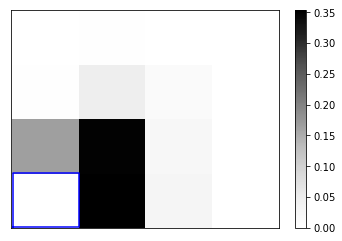

13
[264, 293]
Edades: 13 N: 2


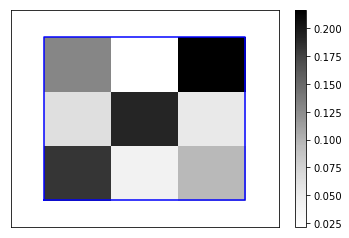

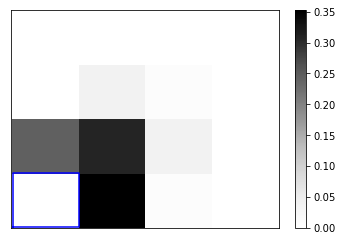

17
[288]
Edades: 17 N: 1


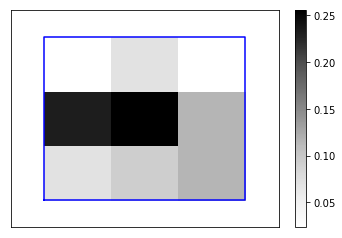

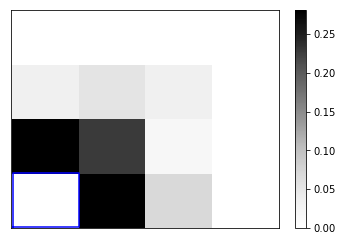

19
[37]
Edades: 19 N: 1


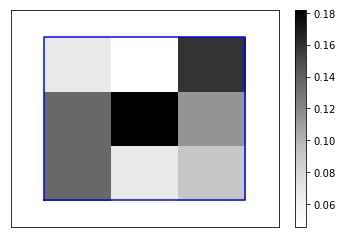

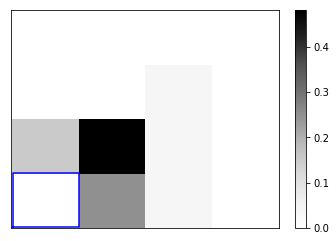

20
[98]
Edades: 20 N: 1


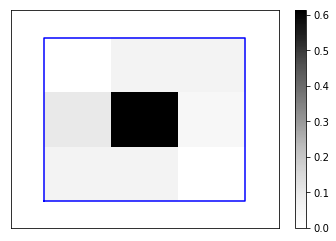

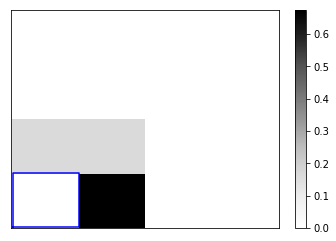

32
[4]
Edades: 32 N: 1


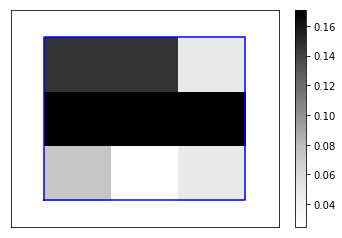

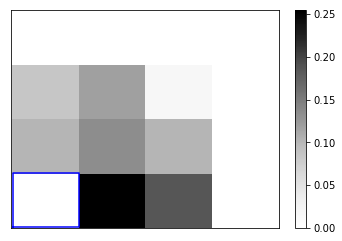

42
[42]
Edades: 42 N: 1


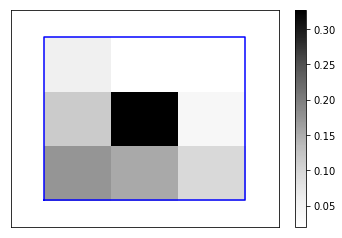

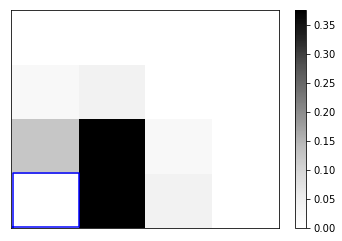

43
[32]
Edades: 43 N: 1


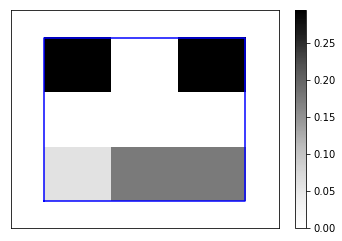

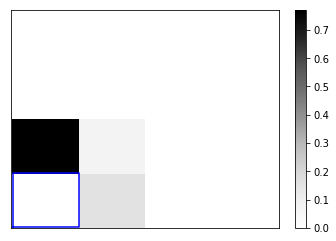

44
[28]
Edades: 44 N: 1


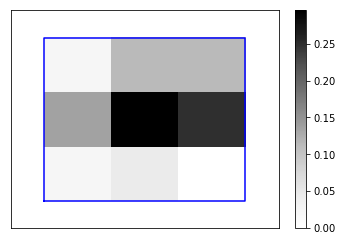

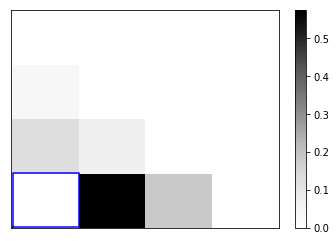

45
[47]
Edades: 45 N: 1


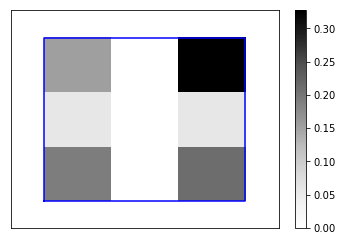

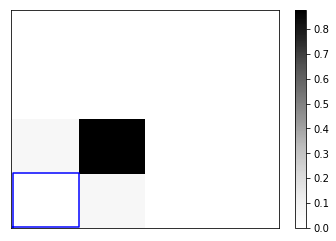

In [13]:

#Rol=Teachers;
#rol='teachers';

Rol=Learners;
rol='learners';

Edades=[];
for subject in Rol:
    Edades.append(subject['age']);
Edades=np.sort(Edades);

#Edades=[[5,6],[7,8],[9,10],[11,12],range(13,99)]


for e in np.unique(Edades):
    print(e)
    N=0;    
    n_i=0;
    n_o=0;
    histo_inside=np.zeros([3,3]);
    histo_outside=np.zeros([4,4]);
    Id=[];
    for subject in Rol:                  
        if (subject['understood'] and subject['age'] == e):
        #if (subject['understood'] and subject['age'] in e):
            N=N+1;
            Id.append(subject['Id']);
            [inner,outer]=individual_histogram(subject);    
            if np.sum(inner)>0:
                n_i=n_i+1;
                histo_inside=histo_inside+inner/np.sum(inner);
            if np.sum(outer)>0:
                n_o=n_o+1;
                histo_outside=histo_outside+outer/np.sum(outer);
                
    
    plt.clf();   
    fig=plt.figure();
    Id.sort();
    print(Id)
    histo_inside=histo_inside/n_i;    
    histo_outside=histo_outside/n_o;    
    print('Edades:',e,'N:',N)
    fig=plt.figure();      
    plt.pcolor(histo_inside,cmap='Greys')     
    plt.colorbar();    
    plt.plot([0,3,3,0,0],[0,0,3,3,0],'b')
    plt.xlim([-0.5,3.5])
    plt.ylim([-0.5,3.5])
    plt.tick_params(bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)    ;
    plt.show()
    #fig.savefig('Age_'+str(e)+'_N_'+str(N)+'_circles_'+rol+'.png',bbox_inches='tight');
    
    
    plt.clf();
    fig=plt.figure();
    plt.title('');
    plt.pcolor(histo_outside,cmap='Greys');
    plt.colorbar();
    plt.plot([0,1,1,0,0],[0,0,1,1,0],'b')
    plt.xlim([-0.03,4])
    plt.ylim([-0.01,4])    
    plt.tick_params(bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False);
    plt.show()
    
    #fig.savefig('Age_'+str(e)+'_N_'+str(N)+'_crosses_'+rol+'.png',bbox_inches='tight');
        
    
    


In [ ]:
set(Edades)

## Corners vs non corners

In [ ]:

Rol=Teachers;
rol='teachers';

#Rol=Learners;
#rol='learners';

Edades=[];
for subject in Rol:
    Edades.append(subject['age']);
Edades=np.sort(Edades);

#for e in np.unique(Edades):
for e in np.unique(Edades):
    print(e)
    N=0;                    
    corners_prop=[];
    non_corners_prop=[];    
    near_prop=[];
    middle_prop=[];
    far_prop=[];
    for subject in Rol:                  
        if (subject['understood'] and subject['age'] == e):
            N=N+1;
            [inner,outer]=individual_histogram(subject);    
            if np.sum(inner)>0:
                n_i=n_i+1;                
                corners=inner[0,0]+inner[0,2]+inner[2,0]+inner[2,2];
                non_corners=np.sum(inner)-corners;
                corners=corners/(np.sum(inner));
                non_corners=non_corners/(np.sum(inner));
                corners_prop.append(corners);
                non_corners_prop.append(non_corners);
            if np.sum(outer)>0:      
                near=(outer[0,1]+outer[1,0]+outer[1,1])/np.sum(outer); # near
                middle=(outer[0,2]+outer[1,2]+outer[2,2]+outer[2,0]+outer[2,1])/np.sum(outer); # middle
                far=1-near-middle;
                near_prop.append(near);
                middle_prop.append(middle);
                far_prop.append(far);
                
    
    # Build the plot
    fig, ax = plt.subplots();    
    ax.bar([1,2], [np.mean(corners_prop),np.mean(non_corners_prop)], yerr=[np.std(corners_prop)/np.sqrt(len(corners_prop)),np.std(non_corners_prop)/np.sqrt(len(non_corners_prop))], align='center', alpha=0.5,facecolor='black' ,ecolor='black', capsize=10)
    ax.set_ylabel('Proportion')
    ax.set_xticks([1,2])
    ax.set_xticklabels(['Corners','Non-corners'])
    ax.set_title(rol)
    plt.show()
    
    fig, ax = plt.subplots();    
    ax.bar([1,2,3], [np.mean(near_prop),np.mean(middle_prop),np.mean(far_prop)], yerr=[np.std(near_prop)/np.sqrt(len(near_prop)),np.std(middle_prop)/np.sqrt(len(middle_prop)),np.std(far_prop)/np.sqrt(len(far_prop))], align='center', alpha=0.5,facecolor='black' ,ecolor='black', capsize=10)
    ax.set_ylabel('Proportion')
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Near','Middle','Far'])
    ax.set_title(rol)
    plt.show()
        
    
    
    







In [ ]:


Teachers
